In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from hmmlearn import hmm
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

### Import processed dataset

In [2]:
df = pd.read_csv('../data/metro_interstate_traffic_volume_processed.csv')

X = df.drop(columns=['traffic_volume', 'traffic_volume_category'])
y = df['traffic_volume_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

### Generate possible observations

In [3]:
day_of_week_categories = ['weekday', 'weekend']
time_of_day_categories = df['time_of_day'].unique()
weather_categories = df['weather'].unique()
temp_categories = df['temp'].unique()
traffic_categories = df['traffic_volume_category'].unique()

observations = list(product(day_of_week_categories, time_of_day_categories, weather_categories))

### Mapping the observations and traffic states to integers

In [4]:
observations_map = {
    '_'.join(obs): i for i, obs in enumerate(observations)
}

state_map = {
    state: i for i, state in enumerate(traffic_categories)
}


def get_observation(row):
    weekday = 'weekend' if row['weekend'] == 1 else 'weekday'
    obs = f"{weekday}_{row['time_of_day']}_{row['weather']}"
    return observations_map[obs]

def get_sequence(data):
    return data.apply(get_observation, axis=1).values.reshape(-1, 1)

### Transition and emission probabilities

In [5]:
def transition_matrix(n_states, states_sequence):
    transition_counts = np.zeros((n_states, n_states))
    for (i, j) in zip(states_sequence[:-1], states_sequence[1:]):
        transition_counts[i, j] += 1

    transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
    return transition_probs


def emission_matrix(n_states, n_observations, states_sequence, observations_sequence):
    emission_counts = np.zeros((n_states, n_observations))
    for state, obs in zip(states_sequence, observations_sequence):
        emission_counts[state, obs] += 1

    emission_probs = emission_counts / emission_counts.sum(axis=1, keepdims=True)
    return emission_probs


def start_probs(n_states, states_sequence):
    start_counts = Counter(states_sequence)
    start_probs = np.array([start_counts[state] for state in range(n_states)])
    start_probs = start_probs / start_probs.sum()
    return start_probs

In [6]:
n_states = len(traffic_categories)
n_observations = len(observations)

states_sequence = y_train.map(state_map).values
observations_sequence = get_sequence(X_train)

# Transition matrix
transition_probs = transition_matrix(n_states, states_sequence)

# Emission matrix
emission_probs = emission_matrix(n_states, n_observations, states_sequence, observations_sequence)

# Start probability
start_probs = start_probs(n_states, states_sequence)

In [7]:
print("Transition matrix:")
for row in transition_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()
    
print("\nEmission matrix:")
for row in emission_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()

print("\nStart probability:")
for prob in start_probs:
    print(f"{prob:.2f}", end=' ')
print()

Transition matrix:
0.78 0.20 0.01 0.00 
0.13 0.69 0.18 0.00 
0.09 0.08 0.68 0.16 
0.02 0.00 0.14 0.84 

Emission matrix:
0.14 0.10 0.05 0.04 0.08 0.02 0.23 0.12 0.07 0.05 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.09 0.06 0.03 0.03 0.04 0.02 0.05 0.03 0.01 0.01 0.01 0.02 0.07 0.05 0.02 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.02 0.01 0.01 0.01 0.01 0.11 0.06 0.03 0.02 0.02 0.01 0.03 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.17 0.14 0.05 0.04 0.04 0.03 0.04 0.03 0.01 0.01 0.02 0.01 0.04 0.04 0.01 0.02 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.07 0.06 0.02 0.02 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.02 0.01 0.01 0.01 0.00 0.18 0.17 0.07 0.05 0.09 0.04 0.01 0.01 0.01 0.01 0.01 0.00 0.00 0

### Create HMM model

In [8]:
model = hmm.CategoricalHMM(n_components=n_states)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

### Test the model on the test set

In [9]:
test_sequence = get_sequence(X_test)
predicted = model.predict(test_sequence)
trues = y_test.map(state_map).values

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=trues, mode='lines', name='True'))
fig.add_trace(go.Scatter(y=predicted, mode='lines', name='Predicted'))

fig.update_layout(
    title="Predicted vs True Values",
    xaxis_title="Index",
    yaxis_title="Value",
    legend=dict(x=0.02, y=0.98)
)
fig.show()

Accuracy: 0.71
F1: 0.69
[[5420  298   33    0]
 [2875 1853 1654    1]
 [ 193  106 4734  974]
 [  26   21  732 5177]]


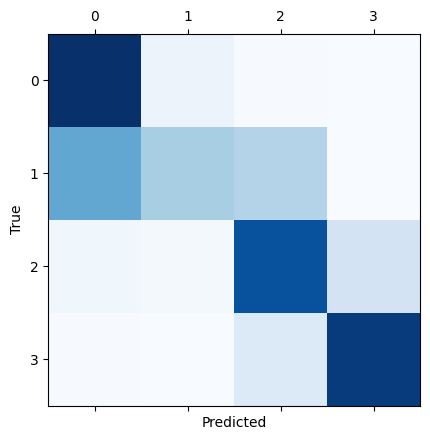

In [11]:
accuracy = accuracy_score(trues, predicted)
f1 = f1_score(trues, predicted, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")

cm = confusion_matrix(trues, predicted)
print(cm)

plt.matshow(cm, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()